In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import colorsys
import json
import math
import os
import random
import time
import warnings

import cv2
import matplotlib
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.coco as coco
import scipy
import torch
import torch.utils.data as data
from matplotlib.patches import Polygon
from progress.bar import Bar
from pycocotools import mask as maskUtils
from pycocotools.cocoeval import COCOeval
from skimage.measure import find_contours

import _init_paths
from config import cfg, update_config
from datasets.dataset_factory import dataset_factory, get_dataset
from detectors.detector_factory import detector_factory
from external.nms import soft_nms
from logger import Logger
from models.decode import (_nms, _topk, _topk_channel,
                           _transpose_and_gather_feat, multi_pose_decode)
from utils.debugger import Debugger
from utils.image import (affine_transform, color_aug, draw_dense_reg,
                         draw_msra_gaussian, draw_umich_gaussian, flip,
                         gaussian_radius, get_affine_transform)
from utils.post_process import multi_pose_post_process
from utils.utils import AverageMeter

from data_inspect_utils import (log, random_colors, apply_mask, 
                                apply_keypoint, display_instances, 
                                extract_bboxes, rotate_bound)

%matplotlib inline

ModuleNotFoundError: No module named '_ext'

In [51]:
def _get_border(border, size):
    i = 1
    while size - border // i <= border // i:
        i *= 2
    return border // i
      
      
def _coco_box_to_bbox(box):
    bbox = np.array([box[0], box[1], box[0] + box[2], box[1] + box[3]],
                    dtype=np.float32)
    return bbox

In [52]:
config = '/home/tensorboy/centerpose/experiments/res_50_512x512.yaml'
img_dir= '/home/tensorboy/data/coco/images/val2017'
anno_path = '/home/tensorboy/data/coco/annotations/person_keypoints_val2017.json'
SAVE_DIR = '/home/tensorboy/data/coco/images/data_loader_vis'
    
update_config(cfg, config)   
    
max_objs = 32
_valid_ids = [1]
class_name = ['__background__', 'person']        
_data_rng = np.random.RandomState(123)
_eig_val = np.array([0.2141788, 0.01817699, 0.00341571], dtype=np.float32)

_eig_vec = np.array([
    [-0.58752847, -0.69563484, 0.41340352],
    [-0.5832747, 0.00994535, -0.81221408],
    [-0.56089297, 0.71832671, 0.41158938]
], dtype=np.float32)


coco_ins = coco.COCO(anno_path)
images = coco_ins.getImgIds()
catIds = coco_ins.getCatIds(class_name[-1])
assert catIds == _valid_ids
images = coco_ins.getImgIds(images,catIds)
num_samples = len(images)  

index = np.random.randint(num_samples)
img_id = images[index]

file_name = coco_ins.loadImgs(ids=[img_id])[0]['file_name']
img_path = os.path.join(img_dir, file_name)
ann_ids = coco_ins.getAnnIds(imgIds=[img_id])
anns = coco_ins.loadAnns(ids=ann_ids)

 
anns = list(filter(lambda x:x['category_id'] in _valid_ids and x['iscrowd']!= 1 , anns))
num_objs = min(len(anns), max_objs)

img = cv2.imread(img_path)

height, width = img.shape[0], img.shape[1]
c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
s = max(img.shape[0], img.shape[1]) * 1.0
rot = 0

num_joints = 17

masks = []
keypoints = []
polys = []
for k in range(num_objs):
    ann = anns[k]
    bbox = ann['bbox']
    pts = np.array(ann['keypoints'], np.float32).reshape(num_joints, 3)
    keypoints.append(pts)    
    segment = coco_ins.annToMask(ann)  
    masks.append(segment)
    polygons = ann['segmentation']  
    polys.append(polygons)
keypoints = np.array(keypoints)
masks = np.array(masks)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


# Bounding Boxes
Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

In [53]:
bboxes = extract_bboxes(masks)

In [54]:
(heigth, width) = img.shape[:2]
(cx, cy) = (width // 2, heigth // 2)

In [55]:
def rot_poly(polys):
    ps = []
    for polygons in polys:
        sub_ps = []
        for p in polygons:
            poly_array = np.array(p).reshape(-1,2)
            sub_ps.append(poly_array)
        ps.append(sub_ps)
    return ps

In [56]:
ps = rot_poly(polys)

In [57]:
def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = [calculated[0],calculated[1]]
    return new_bb

In [58]:
theta = np.random.randint(-45,45)
rotated_image = rotate_bound(img, theta)

rotated_ps = []
for polygons in ps:
    sub_rotate_polys = []
    for p in polygons:
        rotated_p = rotate_box(p, cx, cy, heigth, width, theta)
        r_p = []
        for element in rotated_p:
            r_p+=element
        sub_rotate_polys.append(r_p)
    rotated_ps.append(sub_rotate_polys)
    
for i in range(len(keypoints)):
    single_keypoint = keypoints[i]
    rot_k = rotate_box(single_keypoint, cx, cy, heigth, width, theta)
    keypoints[i,:,:2] = np.array(rot_k)

In [59]:
def annToRLE(segm,h,w):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == list:
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = ann['segmentation']
    return rle

def annToMask(seg_polygons, h, w):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(seg_polygons, h, w)
    m = maskUtils.decode(rle)
    return m

In [60]:
r_h, r_w, _ = rotated_image.shape

rotated_masks = []
for sub_rot_p in rotated_ps:
    binary_masks = annToMask(sub_rot_p, r_h, r_w)
    rotated_masks.append(binary_masks)
rotated_masks = np.array(rotated_masks)

In [61]:
bboxes = extract_bboxes(rotated_masks)

image_id  491464
image                    shape: (428, 640, 3)         min:    0.00000  max:  255.00000  uint8
bbox                     shape: (1, 4)                min:  270.00000  max:  575.00000  int32
mask                     shape: (1, 690, 768)         min:    0.00000  max:    1.00000  uint8
kepoint                  shape: (1, 17, 3)            min:   -0.12813  max:  498.33200  float32


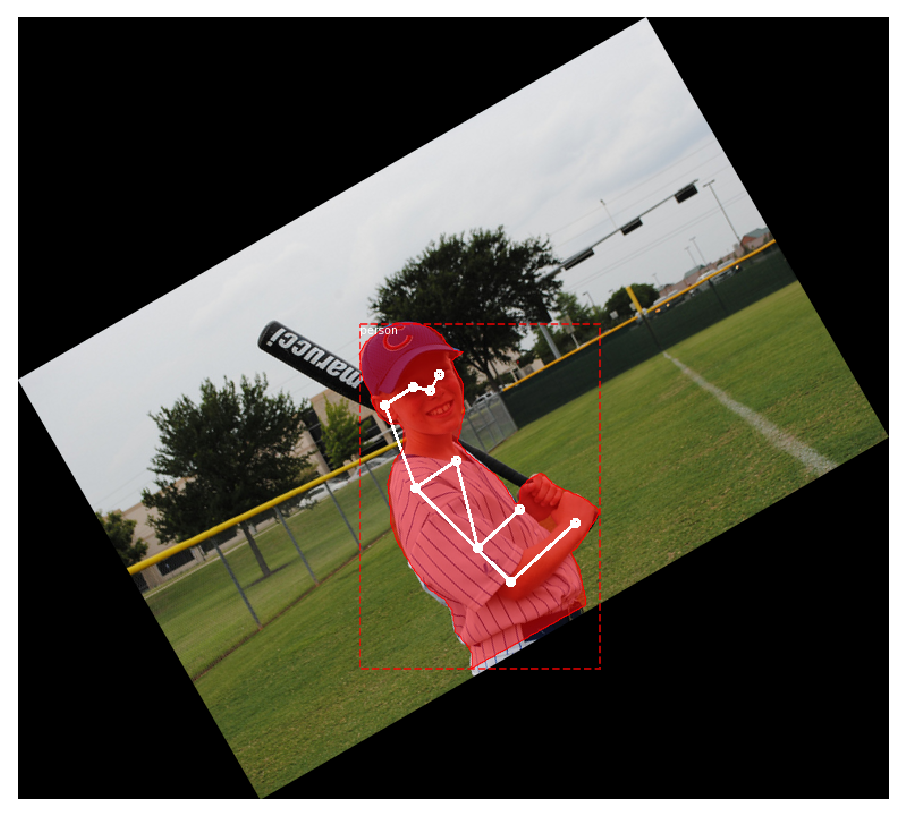

In [62]:
# Display image and additional stats
print("image_id ", img_id)
log("image", img)
log("bbox", bboxes)
log("mask", rotated_masks)
log("kepoint", keypoints)
# Display image and instances
class_ids = np.array([1]*len(bboxes))
class_names = np.array(['person']*len(bboxes))
display_instances(rotated_image[:,:,::-1], bboxes, rotated_masks, keypoints)


In [63]:
flipped = False

s = s * np.random.choice(np.arange(0.6, 1.4, 0.1))
w_border = _get_border(128, img.shape[1])
h_border = _get_border(128, img.shape[0])
c[0] = np.random.randint(low=w_border, high=img.shape[1] - w_border)
c[1] = np.random.randint(low=h_border, high=img.shape[0] - h_border)
    
if np.random.random() <cfg.DATASET.AUG_ROT:
    rf = cfg.DATASET.ROTATE
    rot = np.clip(np.random.randn()*rf, -rf*2, rf*2)

if np.random.random() < cfg.DATASET.FLIP:
    flipped = True
    img = img[:, ::-1, :]
    c[0] =  width - c[0] - 1
        
trans_input = get_affine_transform(
  c, s, rot, [cfg.MODEL.INPUT_RES, cfg.MODEL.INPUT_RES])
inp = cv2.warpAffine(img, trans_input, 
                     (cfg.MODEL.INPUT_RES, cfg.MODEL.INPUT_RES),
                     flags=cv2.INTER_LINEAR)    

In [15]:
output_res = cfg.MODEL.INPUT_RES
num_joints = 17
trans_output_rot = get_affine_transform(c, s, rot, [output_res, output_res])
trans_output = get_affine_transform(c, s, 0, [output_res, output_res])


hm = np.zeros((1, output_res, output_res), dtype=np.float32)
hm_hp = np.zeros((num_joints, output_res, output_res), dtype=np.float32)

In [16]:
draw_gaussian = draw_msra_gaussian if cfg.LOSS.MSE_LOSS else \
                draw_umich_gaussian

In [17]:
flip_idx = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], 
          [11, 12], [13, 14], [15, 16]]

masks = []
bboxes = []
keypoints = []
for k in range(num_objs):
    ann = anns[k]
    bbox = _coco_box_to_bbox(ann['bbox'])
    cls_id = int(ann['category_id']) - 1
    pts = np.array(ann['keypoints'], np.float32).reshape(num_joints, 3)
    keypoints.append(pts)
    segment = coco_ins.annToMask(ann)      
    if flipped:
        bbox[[0, 2]] = width - bbox[[2, 0]] - 1
        pts[:, 0] = width - pts[:, 0] - 1
        for e in flip_idx:
            pts[e[0]], pts[e[1]] = pts[e[1]].copy(), pts[e[0]].copy()
        segment = segment[:, ::-1]     

    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox = np.clip(bbox, 0, output_res - 1)
    segment= cv2.warpAffine(segment, trans_seg_output,
                         (output_res, output_res),
                         flags=cv2.INTER_LINEAR)
    segment = segment.astype(np.float32)      
    masks.append(segment)
    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    bboxes.append([bbox[1], bbox[0], bbox[3], bbox[2]])

    
    
bboxes = np.array(bboxes)
masks = np.array(masks)
keypoints = np.array(keypoints)

extracted_bbox = extract_bboxes(masks)

# Display image and additional stats
print("image_id: ", img_id)
log("image", img)
log("mask", masks)
log("bbox", bbox)
# Display image and instances
display_instances(inp[:,:,::-1], extracted_bbox, masks, keypoints)

NameError: name 'trans_seg_output' is not defined

In [122]:
display_instances(inp[:,:,::-1], bboxes, masks)

TypeError: display_instances() missing 1 required positional argument: 'keypoints'

In [241]:
_data_rng = np.random.RandomState(123)
_eig_val = np.array([0.2141788, 0.01817699, 0.00341571],
                         dtype=np.float32)
_eig_vec = np.array([
    [-0.58752847, -0.69563484, 0.41340352],
    [-0.5832747, 0.00994535, -0.81221408],
    [-0.56089297, 0.71832671, 0.41158938]
], dtype=np.float32)

if not cfg.DATASET.NO_COLOR_AUG:
    color_aug(_data_rng, inp, _eig_val, _eig_vec)

UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [3]:
def gaussian_radius(det_size, min_overlap=0.7):
    height, width = det_size

    a1  = 1
    b1  = (height + width)
    c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
    sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
    r1  = (b1 + sq1) / 2

    a2  = 4
    b2  = 2 * (height + width)
    c2  = (1 - min_overlap) * width * height
    sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
    r2  = (b2 + sq2) / 2

    a3  = 4 * min_overlap
    b3  = -2 * min_overlap * (height + width)
    c3  = (min_overlap - 1) * width * height
    sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
    r3  = (b3 + sq3) / 2
    return min(r1, r2, r3)


In [29]:
def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)

    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]

    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    print('het',heatmap.shape)
    print(y)
    print(top)
    masked_heatmap  = heatmap[int(y - top):int(y + bottom), int(x - left):int(x + right)]
    masked_gaussian = gaussian[int(radius - top):int(radius + bottom), int(radius - left):int(radius + right)]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

het (256, 256)
128
69.96993358544671


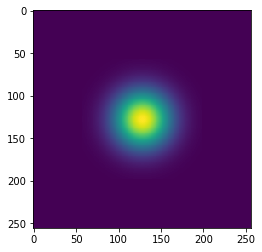

In [31]:
height = 256
width = 256
radius = gaussian_radius((height, width))

white_image = np.zeros((height, width))

center = (int(width/2), int(height/2))
white_image = draw_umich_gaussian(white_image, center, radius)

#cv2.circle(white_image, center, int(np.round(radius)), (0,0,0), 1) 
plt.imshow(white_image*255)

In [69]:
radius

17.492483396361678

In [ ]:
def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.
    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.
    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    print(scale)
    if scale != 1:
        image = cv2.resize(image, (round(w * scale), round(h * scale)),
                       interpolation = cv2.INTER_NEAREST)
    print('scale', scale)
    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = 0
        bottom_pad = max_dim - h - top_pad
        left_pad = 0
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        print('image before padding',image.shape)
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
        print(padding)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))

    return image.astype(image_dtype), window, scale, padding, crop


def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding.
    Typically, you get the scale and padding from resize_image() to
    ensure both, the image and the mask, are resized consistently.
    scale: mask scaling factor
    padding: Padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print('mask shape', mask.shape)
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
        print(scale)
        print('mask shape after', mask.shape)
        print(mask.shape)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

In [ ]:
img, window, scale, padding, _ = resize_image(
    img, 
    min_dim=None, 
    max_dim=512,
    mode='square')
masks = resize_mask(masks.transpose(1,2,0), scale, padding).transpose(2,0,1)
# Compute Bounding box
bbox = extract_bboxes(masks)

# Display image and additional stats
print("image_id: ", img_id)
log("image", img)
log("mask", masks)
log("bbox", bbox)
# Display image and instances
display_instances(img, bbox, masks, class_ids, class_names)